In [1]:
# import packages
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as st
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
random_seed = 616

In [2]:
# load data
dta = pd.read_csv("train_values.csv", sep = ',')
train_labels = pd.read_csv("train_labels.csv", sep = ',')
extracted_col = train_labels["damage_grade"]
data = pd.concat([dta, extracted_col.rename("damage_grade")], axis=1)
data = data.sample(10000)
data.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
107517,644267,4,1276,7958,2,15,6,6,t,r,...,0,0,0,0,0,0,0,0,0,2
23930,643038,6,1277,9802,2,10,9,5,t,r,...,0,0,0,0,0,0,0,0,0,2
228920,541002,27,216,490,4,30,2,9,t,r,...,0,0,0,0,0,0,0,0,0,3
258845,622812,26,1377,4144,2,5,6,5,t,w,...,0,0,0,0,0,0,0,0,0,3
230226,1044706,0,885,8209,2,25,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2


In [3]:
# check training data for missing data
data.isna().sum().sum()

0

In [4]:
# check training labels for missing data
train_labels.isna().any()

building_id     False
damage_grade    False
dtype: bool

<Axes: >

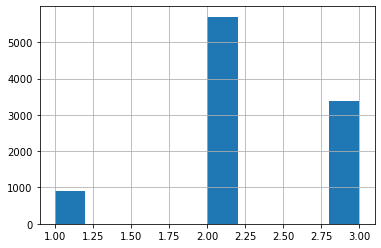

In [5]:
data.damage_grade.hist()

In [6]:
data.describe(include = 'all')

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.0000,10000,10000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.0,10000.0000,10000.000000,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,r,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8341,8379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.260421e+05,13.961700,699.758600,6261.295700,2.13120,26.710500,8.098900,5.4302,NaN,NaN,...,0.032900,0.007200,0.001700,0.000300,0.000800,0.0001,0.0,0.0001,0.005000,2.246400
std,3.049086e+05,8.044135,413.870458,3682.457463,0.72432,73.359661,4.627641,1.8678,NaN,NaN,...,0.178384,0.084551,0.041198,0.017319,0.028274,0.0100,0.0,0.0100,0.070537,0.607391
min,6.100000e+01,0.000000,0.000000,7.000000,1.00000,0.000000,1.000000,2.0000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0000,0.000000,1.000000
25%,2.616465e+05,7.000000,341.500000,3003.000000,2.00000,10.000000,5.000000,4.0000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0000,0.000000,2.000000
50%,5.316220e+05,12.000000,700.000000,6299.000000,2.00000,15.000000,7.000000,5.0000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0000,0.000000,2.000000
75%,7.859192e+05,21.000000,1047.000000,9483.000000,2.00000,30.000000,10.000000,6.0000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0000,0.000000,3.000000


In [7]:
data.damage_grade.value_counts()

damage_grade
2    5704
3    3380
1     916
Name: count, dtype: int64

In [8]:
# modify damage column
map = {1: 0, 2: 1, 3: 1}
data['damage_combined'] = data['damage_grade'].map(map)
data = data.drop('has_superstructure_other', axis=1)
def determine_primary_material(row):
    if row['has_superstructure_adobe_mud']:
        return 'Adobe Mud'
    elif row['has_superstructure_rc_engineered']:
        return 'Engineered RC'
    elif row['has_superstructure_mud_mortar_stone']:
        return'mud_mortar_stone'
    elif row['has_superstructure_stone_flag']:
        return 'stone_flag'
    elif row['has_superstructure_cement_mortar_stone']:
        return 'cement_mortar_stone'
    elif row['has_superstructure_mud_mortar_brick']:
        return 'mud_mortar_brick'
    elif row['has_superstructure_cement_mortar_brick']:
        return 'cement_mortar_brick'
    elif row['has_superstructure_timber']:
        return 'timber'
    elif row['has_superstructure_bamboo']:
        return 'bamboo'
    elif row['has_superstructure_rc_non_engineered']:
        return 'rc_non_engineered'
    elif row['has_superstructure_rc_non_engineered']:
        return 'rc_non_engineered'
    # the other rows
    else:
        return 'other'  # Default category
    
data['primary_material'] = data.apply(determine_primary_material, axis=1)

data = data[data['primary_material'] != 'other']
data['primary_material'] = data['primary_material'].astype('category')
materials = data['primary_material'].cat.categories

train_clean_temp = data.drop(['geo_level_2_id', 'geo_level_3_id', 'height_percentage', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
                               'position', 'plan_configuration', 'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other', 'damage_grade'], axis = 1)

#data['primary_material'] = data.apply(determine_primary_material, axis=1)
train_clean, data_test = train_test_split(train_clean_temp, test_size=0.3, random_state=42)


# Pooled Model:

In [9]:
y_train = train_clean['damage_combined'].values
with pm.Model() as pooled_model:
    count_floors_pre_eq = pm.MutableData("count_floors_pre_eq", train_clean['count_floors_pre_eq'])
    age = pm.MutableData("age", train_clean['age'])
    area_percentage= pm.MutableData("area_percentage", train_clean['area_percentage'])
    geo_level_1_id = pm.MutableData("geo_level_1_id", train_clean['geo_level_1_id'])
    y = pm.MutableData("y", y_train)
    #priors
    alpha = pm.Normal("alpha", mu=0.0, sigma=10)
    beta_age = pm.Normal("beta_age", mu=0.0, sigma=10)       
    beta_count_floors_pre_eq = pm.Normal("beta_count_floors_pre_eq", mu=0.0, sigma=10)       
    beta_area_percentage = pm.Normal("beta_area_percentage", mu=0.0, sigma=10)  
    beta_geo_level_1_id = pm.Normal("beta_geo_level_1_id", mu=0.0, sigma=10)  
    #beta_geo_level_1_id = pm.Normal("beta_geo_level_1_id", mu=0.0, sigma=25)       
    #beta_geo_level_1_id = pm.Normal('geo_level_1_id', mu=0.0, sigma=10.0) 
    # Expected probability using the logistic function
    p = pm.math.invlogit(alpha + beta_count_floors_pre_eq *  count_floors_pre_eq + beta_age * age + beta_area_percentage * area_percentage + geo_level_1_id * beta_geo_level_1_id)
    # Likelihood
    damage_combined = pm.Bernoulli("damage_combined", p=p, observed=y)
    pooled_fit = pm.fit(50000, method='advi')

Finished [100%]: Average Loss = 1,974.2


In [10]:
y_train = train_clean['damage_combined'].values
with pm.Model() as pooled_model:
    count_floors_pre_eq = pm.MutableData("count_floors_pre_eq", train_clean['count_floors_pre_eq'])
    age = pm.MutableData("age", train_clean['age'])
    area_percentage= pm.MutableData("area_percentage", train_clean['area_percentage'])
    geo_level_1_id = pm.MutableData("geo_level_1_id", train_clean['geo_level_1_id'])
    y = pm.MutableData("y", y_train)
    #priors
    alpha = pm.Normal("alpha", mu=0.0, sigma=10)
    beta_age = pm.Normal("beta_age", mu=0.0, sigma=10)       
    beta_count_floors_pre_eq = pm.Normal("beta_count_floors_pre_eq", mu=0.0, sigma=10)       
    beta_area_percentage = pm.Normal("beta_area_percentage", mu=0.0, sigma=10)  
    beta_geo_level_1_id = pm.Normal("beta_geo_level_1_id", mu=0.0, sigma=10)  
    #beta_geo_level_1_id = pm.Normal("beta_geo_level_1_id", mu=0.0, sigma=25)       
    #beta_geo_level_1_id = pm.Normal('geo_level_1_id', mu=0.0, sigma=10.0) 
    # Expected probability using the logistic function
    mu = alpha + beta_count_floors_pre_eq *  count_floors_pre_eq + beta_age * age + beta_area_percentage * area_percentage + geo_level_1_id * beta_geo_level_1_id
    p = pm.Deterministic('p', pm.invlogit(mu))
    # Likelihood
    damage_combined = pm.Bernoulli("damage_combined", p=p, observed=y)
    pooled_fit = pm.fit(50000, method='advi')

Finished [100%]: Average Loss = 1,974.4


In [11]:
g1 = pm.model_to_graphviz(pooled_model)
g1.render("pooled_model", format="png", cleanup=True)

'pooled_model.png'

In [12]:
advi_samples = 5000
pooled__trace = pooled_fit.sample(advi_samples, random_seed=random_seed)

/Users/michaelhammer/miniconda3/envs/bayesml/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (6994) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq'}>,
        <Axes: title={'center': 'beta_area_percentage'}>],
       [<Axes: title={'center': 'beta_geo_level_1_id'}>,
        <Axes: title={'center': 'p\n0'}>,
        <Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n2'}>],
       [<Axes: title={'center': 'p\n3'}>,
        <Axes: title={'center': 'p\n4'}>,
        <Axes: title={'center': 'p\n5'}>,
        <Axes: title={'center': 'p\n6'}>],
       [<Axes: title={'center': 'p\n7'}>,
        <Axes: title={'center': 'p\n8'}>,
        <Axes: title={'center': 'p\n9'}>,
        <Axes: title={'center': 'p\n10'}>],
       [<Axes: title={'center': 'p\n11'}>,
        <Axes: title={'center': 'p\n12'}>,
        <Axes: title={'center': 'p\n13'}>,
        <Axes: title={'center': 'p\n14'}>],
       [<Axes: title={'center': 'p\n15'}>,
        <Axes: title={'center': 'p\n16'}>,
        

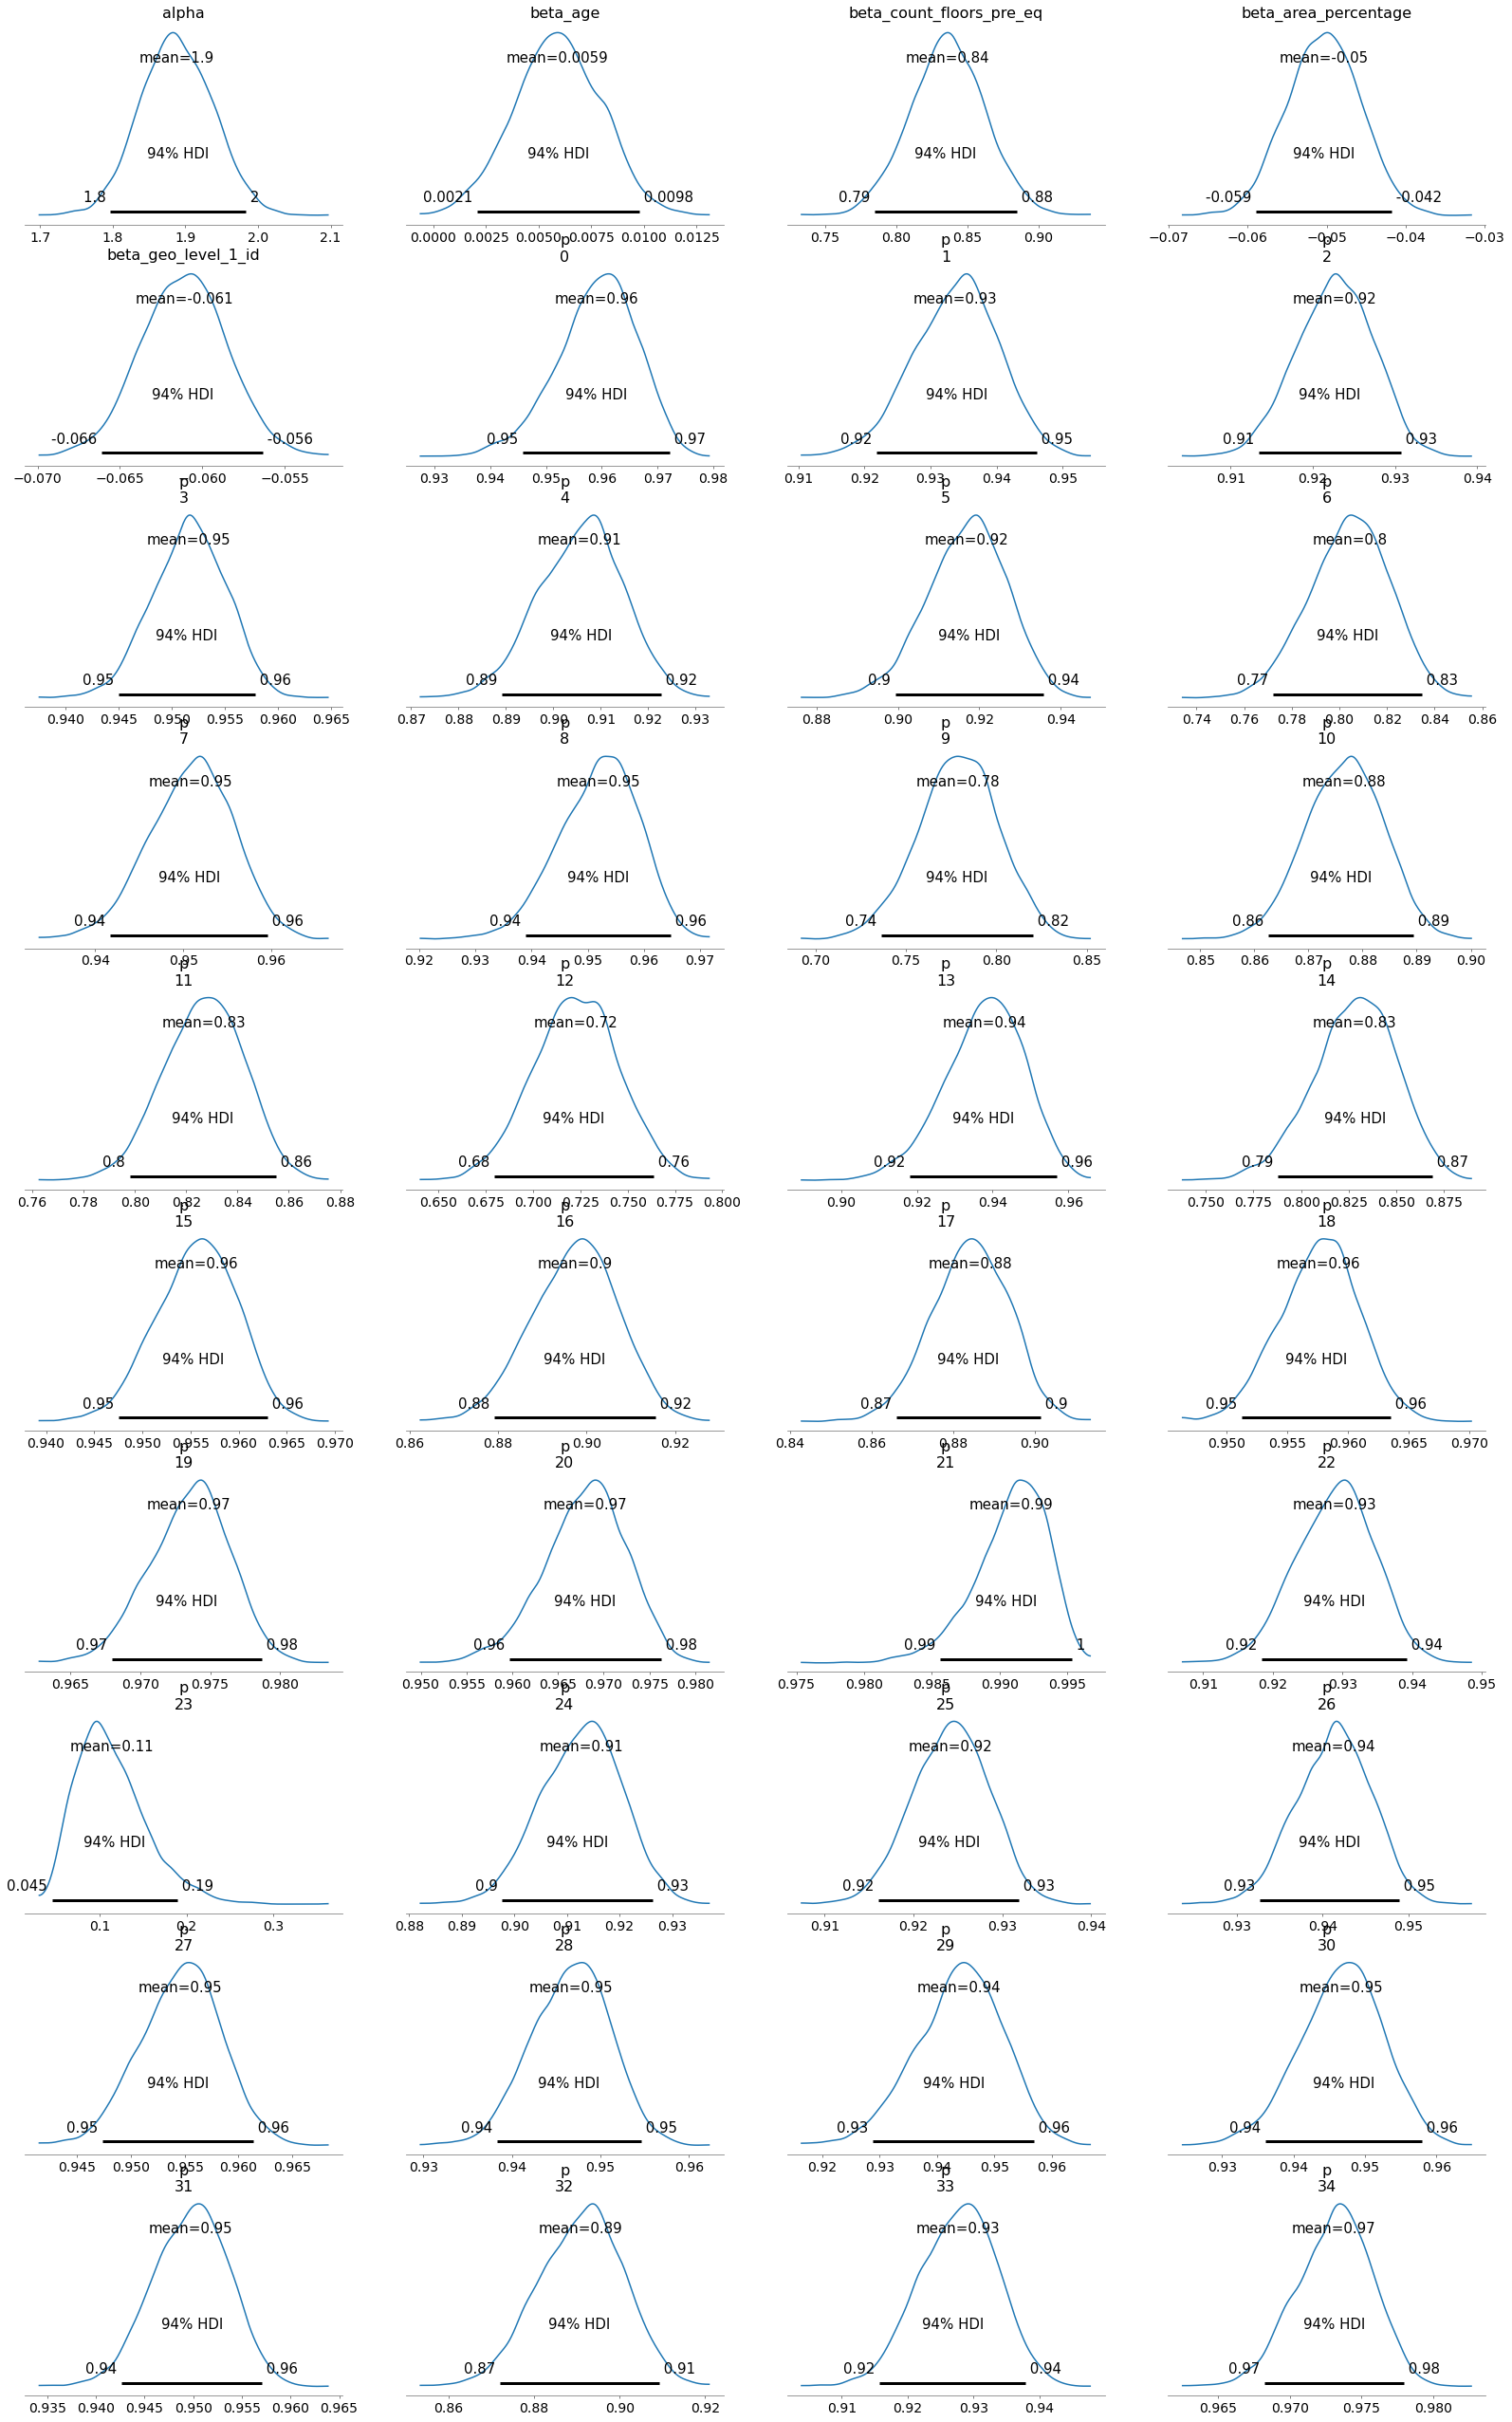

In [13]:
az.plot_posterior(pooled__trace)

In [14]:
advi_samples = 5000
pooled_pp = pm.sample_posterior_predictive(pooled__trace, model = pooled_model)

Sampling: [damage_combined]


Sampling: [damage_combined]


<Axes: title={'center': 'damage_combined / damage_combined'}>

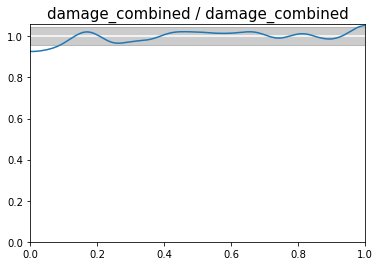

In [15]:
pooled_pp = pm.sample_posterior_predictive(pooled__trace, model = pooled_model)
az.plot_bpv(pooled_pp)

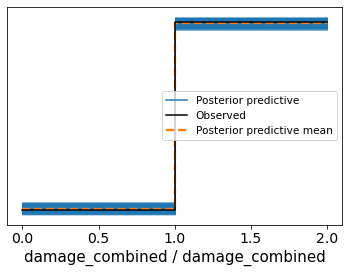

In [20]:
az.plot_ppc(pooled_pp, group='posterior')

# Unpooled model:

In [17]:
coords = {
    "obs_id": np.arange(train_clean.shape[0]),
    "District": train_clean['primary_material'].unique()
}
material_idxx = train_clean.primary_material.unique()
y_train = train_clean['damage_combined'].values
with pm.Model(coords = coords) as unpooled_model:
    material_idx = pm.Data("material_idx", material_idxx, dims="obs_id", mutable=True)
    count_floors_pre_eq = pm.MutableData("count_floors_pre_eq", train_clean['count_floors_pre_eq'])
    age = pm.MutableData("age", train_clean['age'])
    area_percentage= pm.MutableData("area_percentage", train_clean['area_percentage'])
    geo_level_1_id = pm.MutableData("geo_level_1_id", train_clean['geo_level_1_id'])
    y = pm.MutableData("y", y_train)
    #priors
    alpha = pm.Normal("alpha", mu=0.0, sigma=10)
    beta_age = pm.Normal("beta_age", mu=0.0, sigma=10)       
    beta_count_floors_pre_eq = pm.Normal("beta_count_floors_pre_eq", mu=0.0, sigma=10)       
    beta_area_percentage = pm.Normal("beta_area_percentage", mu=0.0, sigma=10)  
    beta_geo_level_1_id = pm.Normal("beta_geo_level_1_id", mu=0.0, sigma=10)  
    # Expected probability using the logistic function
    p = pm.math.invlogit(alpha + beta_count_floors_pre_eq *  count_floors_pre_eq[material_idx] + beta_age * age[material_idx] + beta_area_percentage * area_percentage[material_idx] + geo_level_1_id[material_idx] * beta_geo_level_1_id)
    # Likelihood
    damage_combined = pm.Bernoulli("damage_combined", p=p, observed=y_train)
    pooled_fit = pm.fit(50000, method='advi')

ValueError: could not convert string to float: 'mud_mortar_stone'

# Hierarchical Model:

In [ ]:
#train_clean['geo_level_1_id'] = train_clean.geo_level_1_id.astype('category')
#district_idx = train_clean.geo_level_1_id.cat.codes.values
#unique_districts = train_clean.geo_level_1_id.unique()
#unique_districts2 = np.unique(district_idx2)
#district_id = np.unique(district_idx)
#train_clean['geo_level_1_id'] = train_clean.geo_level_1_id.astype('category')

#age = train_clean['age'].values
#count_floors_pre_eq = train_clean['count_floors_pre_eq'].values
#area_percentage = train_clean['area_percentage'].values
#has_superstructure_adobe_mud = train_clean['has_superstructure_adobe_mud'].values
#has_superstructure_adobe_mud = train_clean['has_superstructure_adobe_mud'].values
#has_superstructure_mud_mortar_stone = train_clean['has_superstructure_mud_mortar_stone'].values
#has_superstructure_stone_flag = train_clean['has_superstructure_stone_flag'].values
#has_superstructure_cement_mortar_stone = train_clean['has_superstructure_cement_mortar_stone'].values
#has_superstructure_mud_mortar_brick = train_clean['has_superstructure_mud_mortar_brick'].values
#has_superstructure_cement_mortar_brick = train_clean['has_superstructure_cement_mortar_brick'].values
#has_superstructure_timber = train_clean['has_superstructure_timber'].values
#has_superstructure_bamboo = train_clean['has_superstructure_bamboo'].values
#has_superstructure_rc_non_engineered = train_clean['has_superstructure_rc_non_engineered'].values
#has_superstructure_rc_engineered = train_clean['has_superstructure_rc_engineered'].values
#has_superstructure_other = train_clean['has_superstructure_other'].values
#damage_combined = train_clean['damage_combined'].values

#with pm.Model() as hierarchical_model:
#    mu_alpha = pm.Normal('mu_alpha', mu=0., sigma=100.)
#    mu_age = pm.Normal('mu_age', mu=0., sigma=100.)
#    mu_count_floors_pre_eq = pm.Normal('mu_count_floors_pre_eq', mu=0., sigma=100.)
#    mu_area_percentage = pm.Normal('mu_area_percentage', mu=0., sigma=100.)
#    mu_has_superstructure_adobe_mud = pm.Normal('mu_has_superstructure_adobe_mud', mu=0., sigma=100.)
#    mu_has_superstructure_mud_mortar_stone = pm.Normal('mu_has_superstructure_mud_mortar_stone', mu=0., sigma=100.)
#    mu_has_superstructure_stone_flag = pm.Normal('mu_has_superstructure_stone_flag', mu=0., sigma=100.)
#    mu_has_superstructure_cement_mortar_stone = pm.Normal('mu_has_superstructure_cement_mortar_stone', mu=0., sigma=100.)
#    mu_has_superstructure_mud_mortar_brick = pm.Normal('mu_has_superstructure_mud_mortar_brick', mu=0., sigma=100.)
#    mu_has_superstructure_cement_mortar_brick = pm.Normal('mu_has_superstructure_cement_mortar_brick', mu=0., sigma=100.)
#    mu_has_superstructure_timber = pm.Normal('mu_has_superstructure_timber', mu=0., sigma=100.)
#    mu_has_superstructure_bamboo = pm.Normal('mu_has_superstructure_bamboo', mu=0., sigma=100.)
#    mu_has_superstructure_rc_non_engineered = pm.Normal('mu_has_superstructure_rc_non_engineered', mu=0., sigma=100.)
#    mu_has_superstructure_rc_engineered = pm.Normal('mu_has_superstructure_rc_engineered', mu=0., sigma=100.)
#    mu_has_superstructure_other = pm.Normal('mu_has_superstructure_other', mu=0., sigma=100.)
#    sd_alpha = pm.HalfNormal('sd_alpha', sigma=100.)
#    sd_age = pm.HalfNormal('sd_age', sigma=100.)
#    sd_count_floors_pre_eq = pm.HalfNormal('sd_count_floors_pre_eq', sigma=100.)
#    sd_area_percentage = pm.HalfNormal('sd_area_percentage', sigma=100.)
#    sd_has_superstructure_adobe_mud = pm.HalfNormal('sd_has_superstructure_adobe_mud', sigma=100.)
#    sd_has_superstructure_mud_mortar_stone = pm.HalfNormal('sd_has_superstructure_mud_mortar_stone', sigma=100.)
#    sd_has_superstructure_stone_flag = pm.HalfNormal('sd_has_superstructure_stone_flag', sigma=100.)
#    sd_has_superstructure_cement_mortar_stone = pm.HalfNormal('sd_has_superstructure_cement_mortar_stone', sigma=100.)
#    sd_has_superstructure_mud_mortar_brick = pm.HalfNormal('sd_has_superstructure_mud_mortar_brick', sigma=100.)
#    sd_has_superstructure_cement_mortar_brick = pm.HalfNormal('sd_has_superstructure_cement_mortar_brick', sigma=100.)
#    sd_has_superstructure_timber = pm.HalfNormal('sd_has_superstructure_timber', sigma=100.)
#    sd_has_superstructure_bamboo = pm.HalfNormal('sd_has_superstructure_bamboo', sigma=100.)
#    sd_has_superstructure_rc_non_engineered = pm.HalfNormal('sd_has_superstructure_rc_non_engineered', sigma=100.)
#    sd_has_superstructure_rc_engineered = pm.HalfNormal('sd_has_superstructure_rc_engineered', sigma=100.)
#    sd_has_superstructure_other = pm.HalfNormal('sd_has_superstructure_other', sigma=100.)

    # District specific intercepts and slopes
#    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sd_alpha, shape=len(train_clean['geo_level_1_id'])) 
#    beta_age = pm.Normal("beta_age", mu=mu_age, sigma=sd_age, shape=len(train_clean['geo_level_1_id'])) 
#    beta_count_floors_pre_eq = pm.Normal("beta_count_floors_pre_eq", mu=mu_count_floors_pre_eq, sigma=sd_count_floors_pre_eq, shape=len(train_clean['geo_level_1_id'])) 
#    beta_area_percentage = pm.Normal("beta_area_percentage", mu=mu_area_percentage, sigma=sd_area_percentage, shape=len(train_clean['geo_level_1_id'])) 
#    beta_has_superstructure_adobe_mud = pm.Normal("beta_has_superstructure_adobe_mud", mu=mu_has_superstructure_adobe_mud, sigma=sd_has_superstructure_adobe_mud, shape=len(train_clean['geo_level_1_id'])) 
#    beta_has_superstructure_mud_mortar_stone = pm.Normal("beta_has_superstructure_mud_mortar_stone", mu=mu_has_superstructure_mud_mortar_stone, sigma=sd_has_superstructure_mud_mortar_stone, shape=len(train_clean['geo_level_1_id'])) 
#    beta_has_superstructure_stone_flag = pm.Normal("beta_has_superstructure_stone_flag", mu=mu_has_superstructure_stone_flag, sigma=sd_has_superstructure_stone_flag, shape=len(train_clean['geo_level_1_id'])) 
#    beta_has_superstructure_cement_mortar_stone = pm.Normal("beta_has_superstructure_cement_mortar_stone", mu=mu_has_superstructure_cement_mortar_stone, sigma=sd_has_superstructure_cement_mortar_stone, shape=len(train_clean['geo_level_1_id']))  
#    beta_has_superstructure_mud_mortar_brick = pm.Normal("beta_has_superstructure_mud_mortar_brick", mu=mu_has_superstructure_mud_mortar_brick, sigma=sd_has_superstructure_mud_mortar_brick, shape=len(train_clean['geo_level_1_id']))   
#    beta_has_superstructure_cement_mortar_brick = pm.Normal("beta_has_superstructure_cement_mortar_brick", mu=mu_has_superstructure_cement_mortar_brick, sigma=sd_has_superstructure_cement_mortar_brick, shape=len(train_clean['geo_level_1_id']))       
#    beta_has_superstructure_timber = pm.Normal("beta_has_superstructure_timber", mu=mu_has_superstructure_timber, sigma=sd_has_superstructure_timber, shape=len(train_clean['geo_level_1_id'])) 
#    beta_has_superstructure_bamboo = pm.Normal("beta_has_superstructure_bamboo", mu=mu_has_superstructure_bamboo, sigma=sd_has_superstructure_bamboo,shape=len(train_clean['geo_level_1_id'])) 
#    beta_has_superstructure_rc_non_engineered = pm.Normal("beta_has_superstructure_rc_non_engineered", mu=mu_has_superstructure_rc_non_engineered, sigma=sd_has_superstructure_rc_non_engineered, shape=len(train_clean['geo_level_1_id'])) 
#    beta_has_superstructure_rc_engineered = pm.Normal("beta_has_superstructure_rc_engineered", mu=mu_has_superstructure_rc_engineered, sigma=sd_has_superstructure_rc_engineered, shape=len(train_clean['geo_level_1_id'])) 
#    beta_has_superstructure_other = pm.Normal("beta_has_superstructure_other", mu=mu_has_superstructure_other, sigma=sd_has_superstructure_other, shape=len(train_clean['geo_level_1_id'])) 

    # Expected value
#    district_idx = train_clean['geo_level_1_id'].cat.codes.values
    #mu = pm.math.invlogit(alpha[district_idx] + beta[district_idx] * bang_df['age.centered'])  # Logit link function
#    mu = pm.math.invlogit(
#        alpha[district_idx] +
#        beta_age[district_idx] * age +
#        beta_count_floors_pre_eq[district_idx] * count_floors_pre_eq +
#        beta_area_percentage[district_idx] * area_percentage +
#        beta_has_superstructure_adobe_mud[district_idx] * has_superstructure_adobe_mud +
#        beta_has_superstructure_mud_mortar_stone[district_idx] * has_superstructure_mud_mortar_stone +
#        beta_has_superstructure_stone_flag[district_idx] * has_superstructure_stone_flag +
#        beta_has_superstructure_cement_mortar_stone[district_idx] * has_superstructure_cement_mortar_stone +
#        beta_has_superstructure_mud_mortar_brick[district_idx] * has_superstructure_mud_mortar_brick +
#        beta_has_superstructure_cement_mortar_brick[district_idx] * has_superstructure_cement_mortar_brick +
#        beta_has_superstructure_timber[district_idx] * has_superstructure_timber +
#        beta_has_superstructure_bamboo[district_idx] * has_superstructure_bamboo +
#        beta_has_superstructure_rc_non_engineered[district_idx] * has_superstructure_rc_non_engineered +
#        beta_has_superstructure_rc_engineered[district_idx] * has_superstructure_rc_engineered +
#        beta_has_superstructure_other[district_idx] * has_superstructure_other)
    
    # Storing mu in the trace using pm.Deterministic
#    p = pm.Deterministic('p', mu)
    # Likelihood
#    y = pm.Bernoulli('y', p=mu, observed=damage_combined)

    #hierarchical_trace = pm.sample(1000, tune=1000, target_accept = 0.9)
#    hierarchical_approx = pm.fit(method='advi')
#    hierarchical_trace = hierarchical_approx.sample(draws = 1000)

Finished [100%]: Average Loss = 1.2855e+06


: 

In [ ]:
#def determine_primary_material(row):
#    if row['has_superstructure_adobe_mud']:
#        return 'Adobe Mud'
#    elif row['has_superstructure_rc_engineered']:
#        return 'Engineered RC'
#    elif row['has_superstructure_mud_mortar_stone']:
#        return'mud_mortar_stone'
#    elif row['has_superstructure_stone_flag']:
#        return 'stone_flag'
#    elif row['has_superstructure_cement_mortar_stone']:
#        return 'cement_mortar_stone'
#    elif row['has_superstructure_mud_mortar_brick']:
#        return 'mud_mortar_brick'
#    elif row['has_superstructure_cement_mortar_brick']:
#        return 'cement_mortar_brick'
#    elif row['has_superstructure_timber']:
#        return 'timber'
#    elif row['has_superstructure_bamboo']:
#        return 'bamboo'
#    elif row['has_superstructure_rc_non_engineered']:
#        return 'rc_non_engineered'
#    elif row['has_superstructure_rc_non_engineered']:
#        return 'rc_non_engineered'
#    # the other rows
#    else:
#        return 'other'  # Default category
    

#train_clean = data_train.drop('has_superstructure_other', axis=1)
#train_clean['primary_material'] = train_clean.apply(determine_primary_material, axis=1)
#train_clean.head(10).T

,0,1,2,3,4,5,6,7,8,9
building_id,802906,28830,94947,590882,201944,333020,728451,475515,441126,989500
geo_level_1_id,6,8,21,22,11,8,9,20,0,26
geo_level_2_id,487,900,363,418,131,558,475,323,757,886
geo_level_3_id,12198,2812,8973,10694,1488,6089,12066,12236,7219,994
count_floors_pre_eq,2,2,2,2,3,2,2,2,2,1
age,30,10,10,10,30,10,25,0,15,0
area_percentage,6,8,5,6,8,9,3,8,8,13
height_percentage,5,7,5,5,9,5,4,6,6,4
land_surface_condition,t,o,t,t,t,t,n,t,t,t
foundation_type,r,r,r,r,r,r,r,w,r,i


In [ ]:
#train_clean = train_clean[train_clean['primary_material'] != 'other']
##
#train_clean['primary_material'] = train_clean['primary_material'].astype('category')
materials = train_clean['primary_material'].cat.categories

In [ ]:
#with pm.Model() as hier_material:
#    # Hyperpriors for group intercepts and slopes
#    mu_alpha = pm.Normal('mu_alpha', mu=0., sigma=100.)
#    mu_beta = pm.Normal('mu_beta', mu=0., sigma=100.)
#    sd_alpha = pm.HalfNormal('sd_alpha', sigma=100.)
#    sd_beta = pm.HalfNormal('sd_beta', sigma=100.)
    
    # District specific intercepts and slopes
#    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sd_alpha, shape=len(materials))
 #   beta_count_floors_pre_eq = pm.Normal('beta_count_floors_pre_eq', mu=mu_beta, sigma=sd_beta, shape=len(materials))
 #   beta_age = pm.Normal('beta_age', mu=mu_beta, sigma=sd_beta, shape=len(materials))
  #  beta_area_percentage = pm.Normal('beta_area_percentage', mu=mu_beta, sigma=sd_beta, shape=len(materials))
    
    # Expected value
#    material_idx = train_clean['primary_material'].cat.codes.values
#    mu = pm.math.invlogit(alpha[material_idx] + beta_count_floors_pre_eq[material_idx] * train_clean['count_floors_pre_eq'] + 
#                          beta_age[material_idx] * train_clean['age'] +
#                          beta_area_percentage[material_idx] * train_clean['area_percentage'])  # Logit link function

    # Storing mu in the trace using pm.Deterministic
#    p = pm.Deterministic('p', mu)
    
    # Likelihood
#    use_contraception = pm.Bernoulli('use_contraception', p=mu, observed=train_clean['damage_combined'])

    # Sample from the model
#    hierarchical_approx = pm.fit(method='advi')
#    hierarchical_trace = hierarchical_approx.sample(draws = 10000)


Finished [100%]: Average Loss = 2.0619e+05


In [28]:
y_train = train_clean['damage_combined'].values
material_idx = train_clean['primary_material'].cat.codes.values
with pm.Model() as hier_model:
    count_floors_pre_eq = pm.MutableData("count_floors_pre_eq", train_clean['count_floors_pre_eq'])
    age = pm.MutableData("age", train_clean['age'])
    area_percentage = pm.MutableData("area_percentage", train_clean['area_percentage'])
    geo_level_1_id = pm.MutableData("geo_level_1_id", train_clean['geo_level_1_id'])
    y = pm.MutableData("y", y_train)
    material_idx = pm.MutableData('material_idx', material_idx)

    #hyperpriors:
    mu_alpha = pm.Normal('mu_alpha', mu=0., sigma=100.)
    mu_beta = pm.Normal('mu_beta', mu=0., sigma=100.)
    sd_alpha = pm.HalfCauchy('sd_alpha', 100.)
    sd_beta = pm.HalfCauchy('sd_beta', 100.)


    # Superstructure specific intercepts and slopes
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sd_alpha, shape=len(materials))
    beta_count_floors_pre_eq = pm.Normal('beta_count_floors_pre_eq', mu=mu_beta, sigma=sd_beta, shape=len(materials))
    beta_age = pm.Normal('beta_age', mu=mu_beta, sigma=sd_beta, shape=len(materials))
    beta_area_percentage = pm.Normal('beta_area_percentage', mu=mu_beta, sigma=sd_beta, shape=len(materials))
    beta_geo_level_1_id = pm.Normal("beta_geo_level_1_id", mu=mu_beta, sigma=sd_beta, shape=len(materials))
    # Expected value
    #material_idx = train_clean['primary_material'].cat.codes.values
    mu = pm.math.invlogit(alpha[material_idx] + beta_count_floors_pre_eq[material_idx] * count_floors_pre_eq + 
                          beta_age[material_idx] * age +
                          beta_area_percentage[material_idx] * area_percentage +
                          beta_geo_level_1_id[material_idx] * geo_level_1_id)  # Logit link function
    # Storing mu in the trace using pm.Deterministic
    p = pm.Deterministic('p', mu)
    # Likelihood
    damage_combined = pm.Bernoulli('damage_combined', p=mu, observed=y)
    hier_fit = pm.fit(50000, method='advi', random_seed=random_seed)

Finished [100%]: Average Loss = 1,696.6


In [ ]:
g2 = pm.model_to_graphviz(hier_model)
g2.render("hier_model", format="png", cleanup=True)

'hier_model.png'

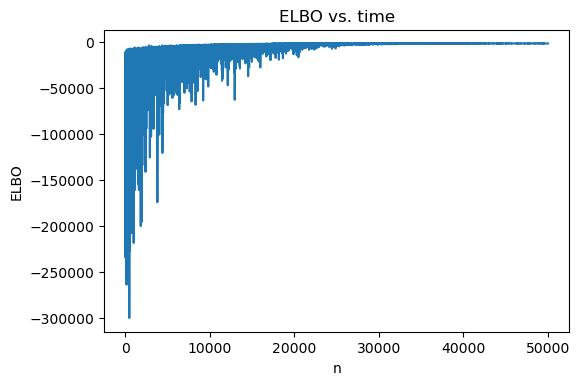

In [ ]:
advi_elbo = pd.DataFrame(
    {'ELBO': -hier_fit.hist,
     'n': np.arange(hier_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

In [29]:
advi_samples = 5000
hier__trace = hier_fit.sample(advi_samples)

/Users/michaelhammer/miniconda3/envs/bayesml/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (7047) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'mu_alpha'}>,
        <Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>],
       [<Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n3'}>,
        <Axes: title={'center': 'alpha\n4'}>,
        <Axes: title={'center': 'alpha\n5'}>],
       [<Axes: title={'center': 'alpha\n6'}>,
        <Axes: title={'center': 'alpha\n7'}>,
        <Axes: title={'center': 'alpha\n8'}>,
        <Axes: title={'center': 'alpha\n9'}>],
       [<Axes: title={'center': 'beta_count_floors_pre_eq\n0'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq\n1'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq\n2'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq\n3'}>],
       [<Axes: title={'center': 'beta_count_floors_pre_eq\n4'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq\n5'}>,
        <Axes: title={'center': 'beta_count_floors_pre_

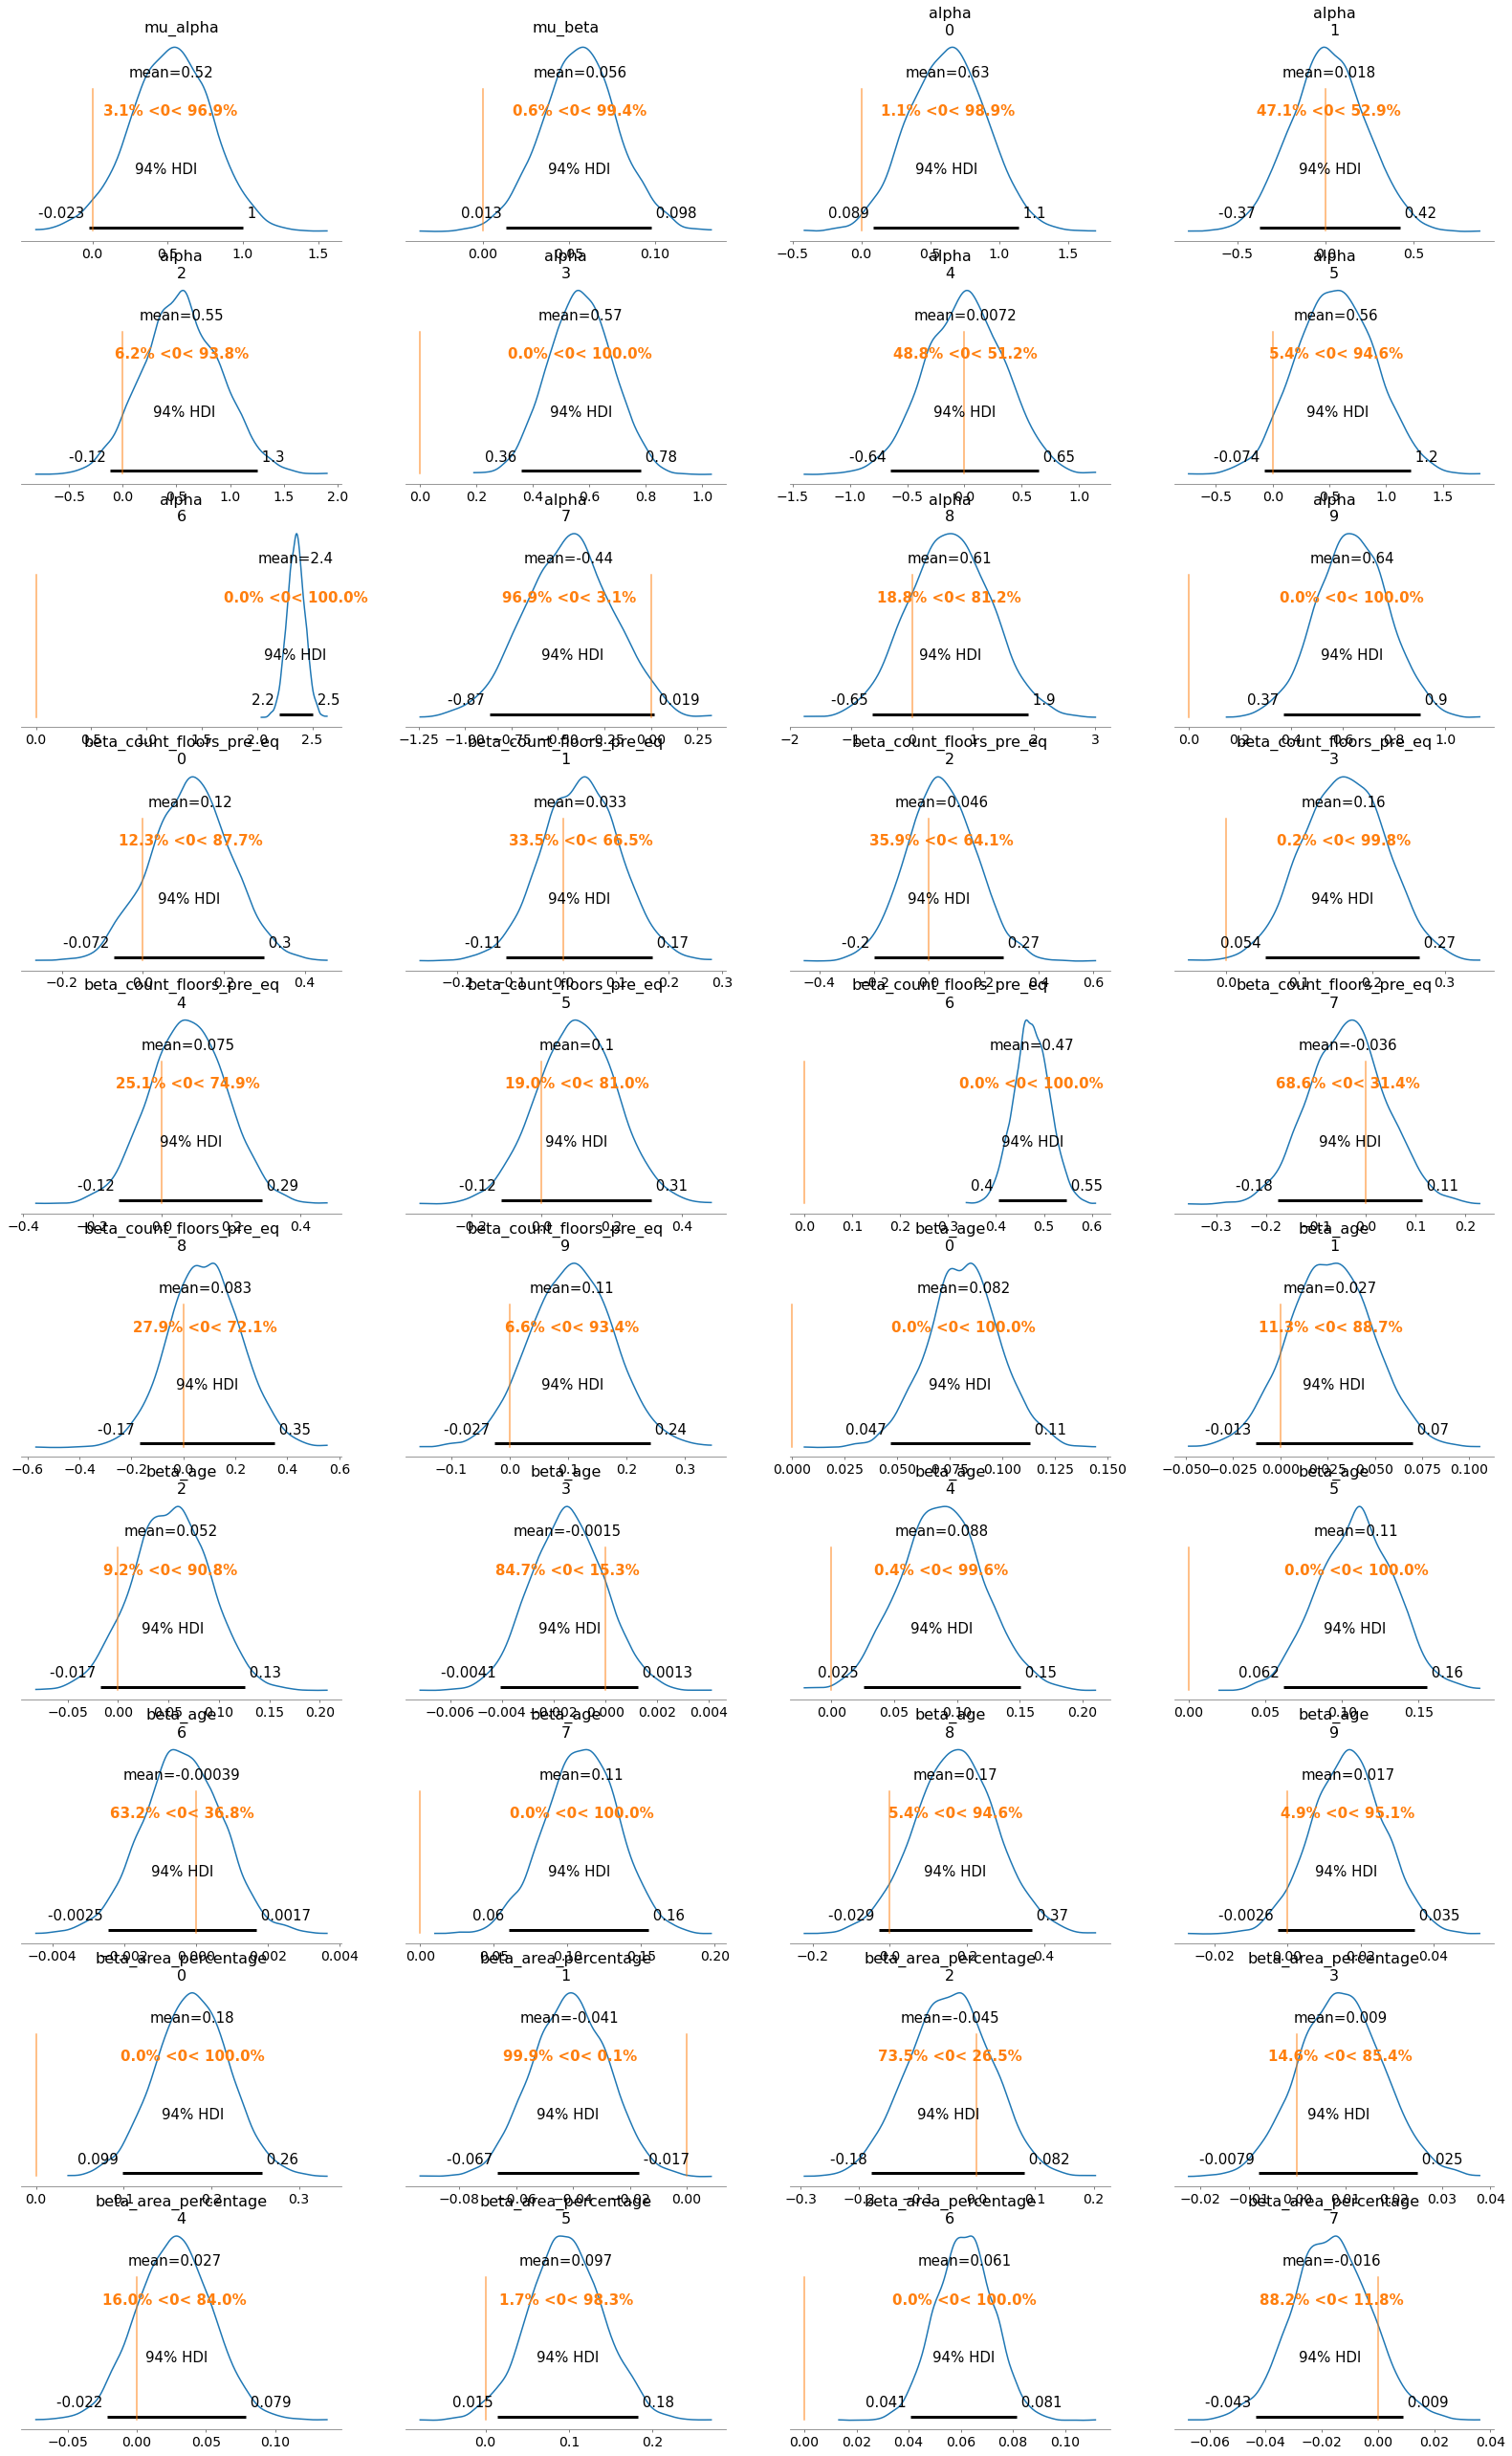

In [ ]:
az.plot_posterior(hier__trace, ref_val = 0)

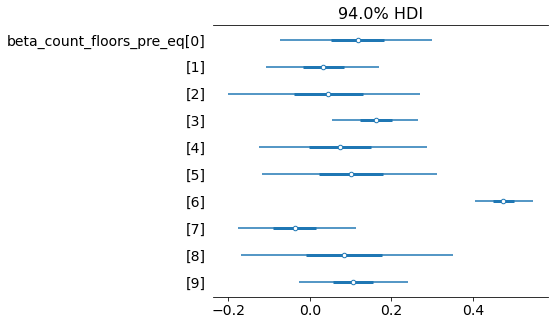

In [ ]:
with hier_model:
    az.plot_forest(hier__trace, var_names=['beta_count_floors_pre_eq'])

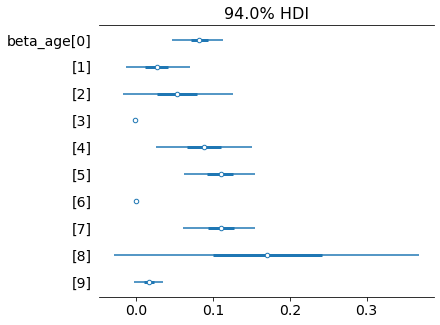

In [ ]:
with hier_model:
    az.plot_forest(hier__trace, var_names=['beta_age'])

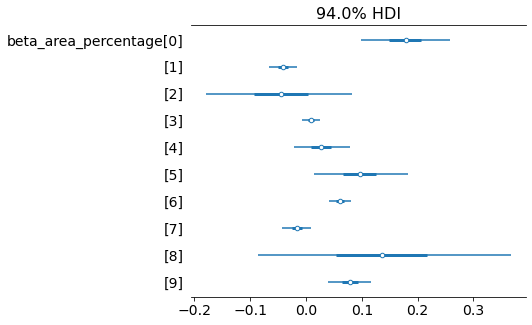

In [ ]:
with hier_model:
    az.plot_forest(hier__trace, var_names=['beta_area_percentage'])

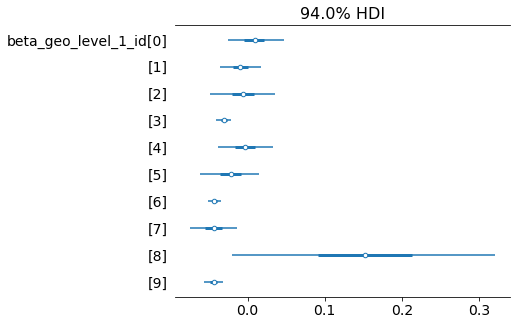

In [ ]:
with hier_model:
    az.plot_forest(hier__trace, var_names =['beta_geo_level_1_id'])

In [ ]:
with hier_model:
    posterior_predictive = pm.sample_posterior_predictive(hier__trace)


predictions = posterior_predictive.posterior_predictive['damage_combined'].values


'''

num_samples = predictions.shape[0]
#observed = train_clean.damage_combined.values 
observed = train_clean.damage_combined.values  

# Initialize matrices to hold counts
TP = np.zeros(num_samples)
FP = np.zeros(num_samples)
TN = np.zeros(num_samples)
FN = np.zeros(num_samples)

for i in range(num_samples):
    TP[i] = np.sum((predictions[i] == 1) & (observed == 1))
    FP[i] = np.sum((predictions[i] == 1) & (observed == 0))
    TN[i] = np.sum((predictions[i] == 0) & (observed == 0))
    FN[i] = np.sum((predictions[i] == 0) & (observed == 1))


'''

Sampling: [damage_combined]


'\n\nnum_samples = predictions.shape[0]\n#observed = train_clean.damage_combined.values \nobserved = train_clean.damage_combined.values  \n\n# Initialize matrices to hold counts\nTP = np.zeros(num_samples)\nFP = np.zeros(num_samples)\nTN = np.zeros(num_samples)\nFN = np.zeros(num_samples)\n\nfor i in range(num_samples):\n    TP[i] = np.sum((predictions[i] == 1) & (observed == 1))\n    FP[i] = np.sum((predictions[i] == 1) & (observed == 0))\n    TN[i] = np.sum((predictions[i] == 0) & (observed == 0))\n    FN[i] = np.sum((predictions[i] == 0) & (observed == 1))\n\n\n'

In [ ]:
num_draws = predictions.shape[1]
num_samples = predictions.shape[2]
observed = train_clean['damage_combined'].values  # Replace with your actual observed values

TP = np.zeros(num_draws)
FP = np.zeros(num_draws)
TN = np.zeros(num_draws)
FN = np.zeros(num_draws)

# Iterate over draws
for i in range(num_draws):
    # Average predictions over chains if needed, or thresholding if they are probabilities
    # Here it's assumed they are binary (0 or 1)
    pred_draw = predictions[0, i, :].astype(int)  # 0 index for chain

    TP[i] = np.sum((pred_draw == 1) & (observed == 1))
    FP[i] = np.sum((pred_draw == 1) & (observed == 0))
    TN[i] = np.sum((pred_draw == 0) & (observed == 0))
    FN[i] = np.sum((pred_draw == 0) & (observed == 1))



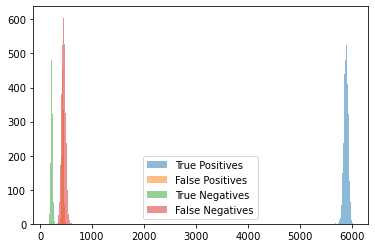

In [ ]:

plt.hist(TP, bins=30, alpha=0.5, label='True Positives')
plt.hist(FP, bins=30, alpha=0.5, label='False Positives')
plt.hist(TN, bins=30, alpha=0.5, label='True Negatives')
plt.hist(FN, bins=30, alpha=0.5, label='False Negatives')
plt.legend()
plt.show()

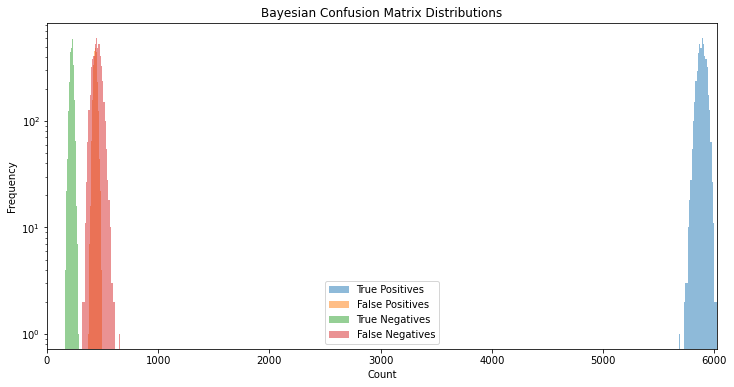

In [ ]:

plt.figure(figsize=(12, 6))

plt.yscale('log')

# Plot histograms for each cell of the confusion matrix
plt.hist(TP, bins=30, alpha=0.5, label='True Positives', log=True)
plt.hist(FP, bins=30, alpha=0.5, label='False Positives', log=True)
plt.hist(TN, bins=30, alpha=0.5, label='True Negatives', log=True)
plt.hist(FN, bins=30, alpha=0.5, label='False Negatives', log=True)

# Set limits on the x-axis if necessary
plt.xlim([0, np.max([TP.max(), FP.max(), TN.max(), FN.max()])])

plt.legend()
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Bayesian Confusion Matrix Distributions')
plt.show()


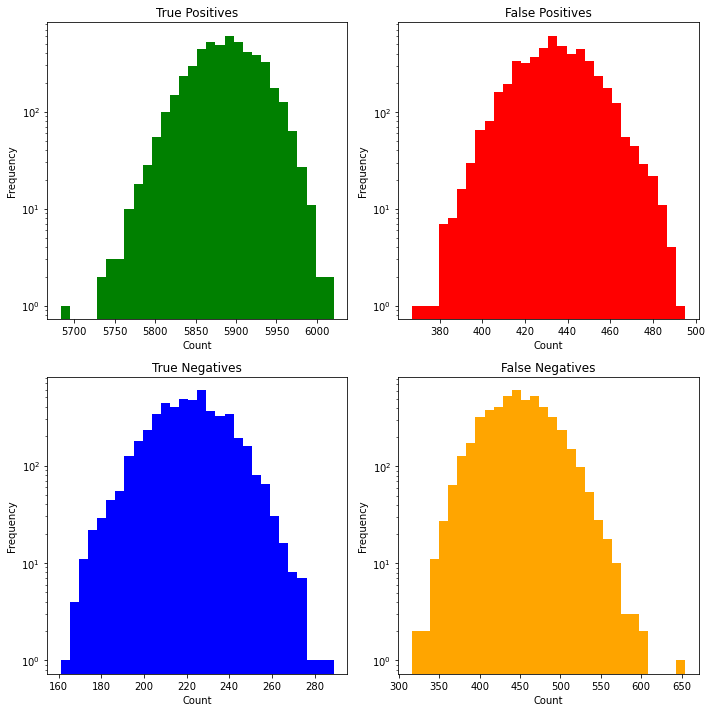

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# True Positives
axes[0, 0].hist(TP, bins=30, color='green', log=True)
axes[0, 0].set_title('True Positives')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Frequency')

# False Positives
axes[0, 1].hist(FP, bins=30, color='red', log=True)
axes[0, 1].set_title('False Positives')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Frequency')

# True Negatives
axes[1, 0].hist(TN, bins=30, color='blue', log=True)
axes[1, 0].set_title('True Negatives')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Frequency')

# False Negatives
axes[1, 1].hist(FN, bins=30, color='orange', log=True)
axes[1, 1].set_title('False Negatives')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Frequency')

fig.tight_layout()

plt.show()


In [ ]:
with hier_model:
    hier_idata = pm.sample_prior_predictive(samples=50, random_seed=random_seed)
    hier_pp = pm.sample_posterior_predictive(hier__trace, random_seed = random_seed)

Sampling: [alpha, beta_age, beta_area_percentage, beta_count_floors_pre_eq, beta_geo_level_1_id, damage_combined, mu_alpha, mu_beta, sd_alpha, sd_beta]
Sampling: [damage_combined]


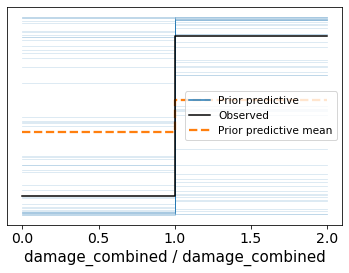

In [ ]:
az.plot_ppc(hier_idata, group="prior");

<Axes: xlabel='damage_combined / damage_combined'>

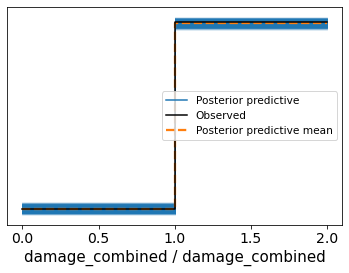

In [ ]:
az.plot_ppc(hier_pp, group='posterior')
        

<Axes: title={'center': 'damage_combined / damage_combined'}>

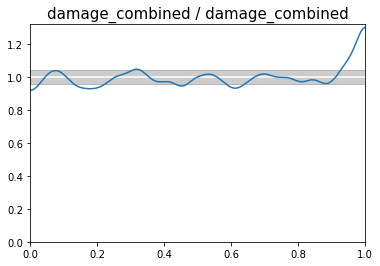

In [ ]:
az.plot_bpv(hier_pp)

/Users/michaelhammer/miniconda3/envs/bayesml/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (7047) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'mu_alpha'}>,
        <Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>],
       [<Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n3'}>,
        <Axes: title={'center': 'alpha\n4'}>,
        <Axes: title={'center': 'alpha\n5'}>],
       [<Axes: title={'center': 'alpha\n6'}>,
        <Axes: title={'center': 'alpha\n7'}>,
        <Axes: title={'center': 'alpha\n8'}>,
        <Axes: title={'center': 'alpha\n9'}>],
       [<Axes: title={'center': 'beta_count_floors_pre_eq\n0'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq\n1'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq\n2'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq\n3'}>],
       [<Axes: title={'center': 'beta_count_floors_pre_eq\n4'}>,
        <Axes: title={'center': 'beta_count_floors_pre_eq\n5'}>,
        <Axes: title={'center': 'beta_count_floors_pre_

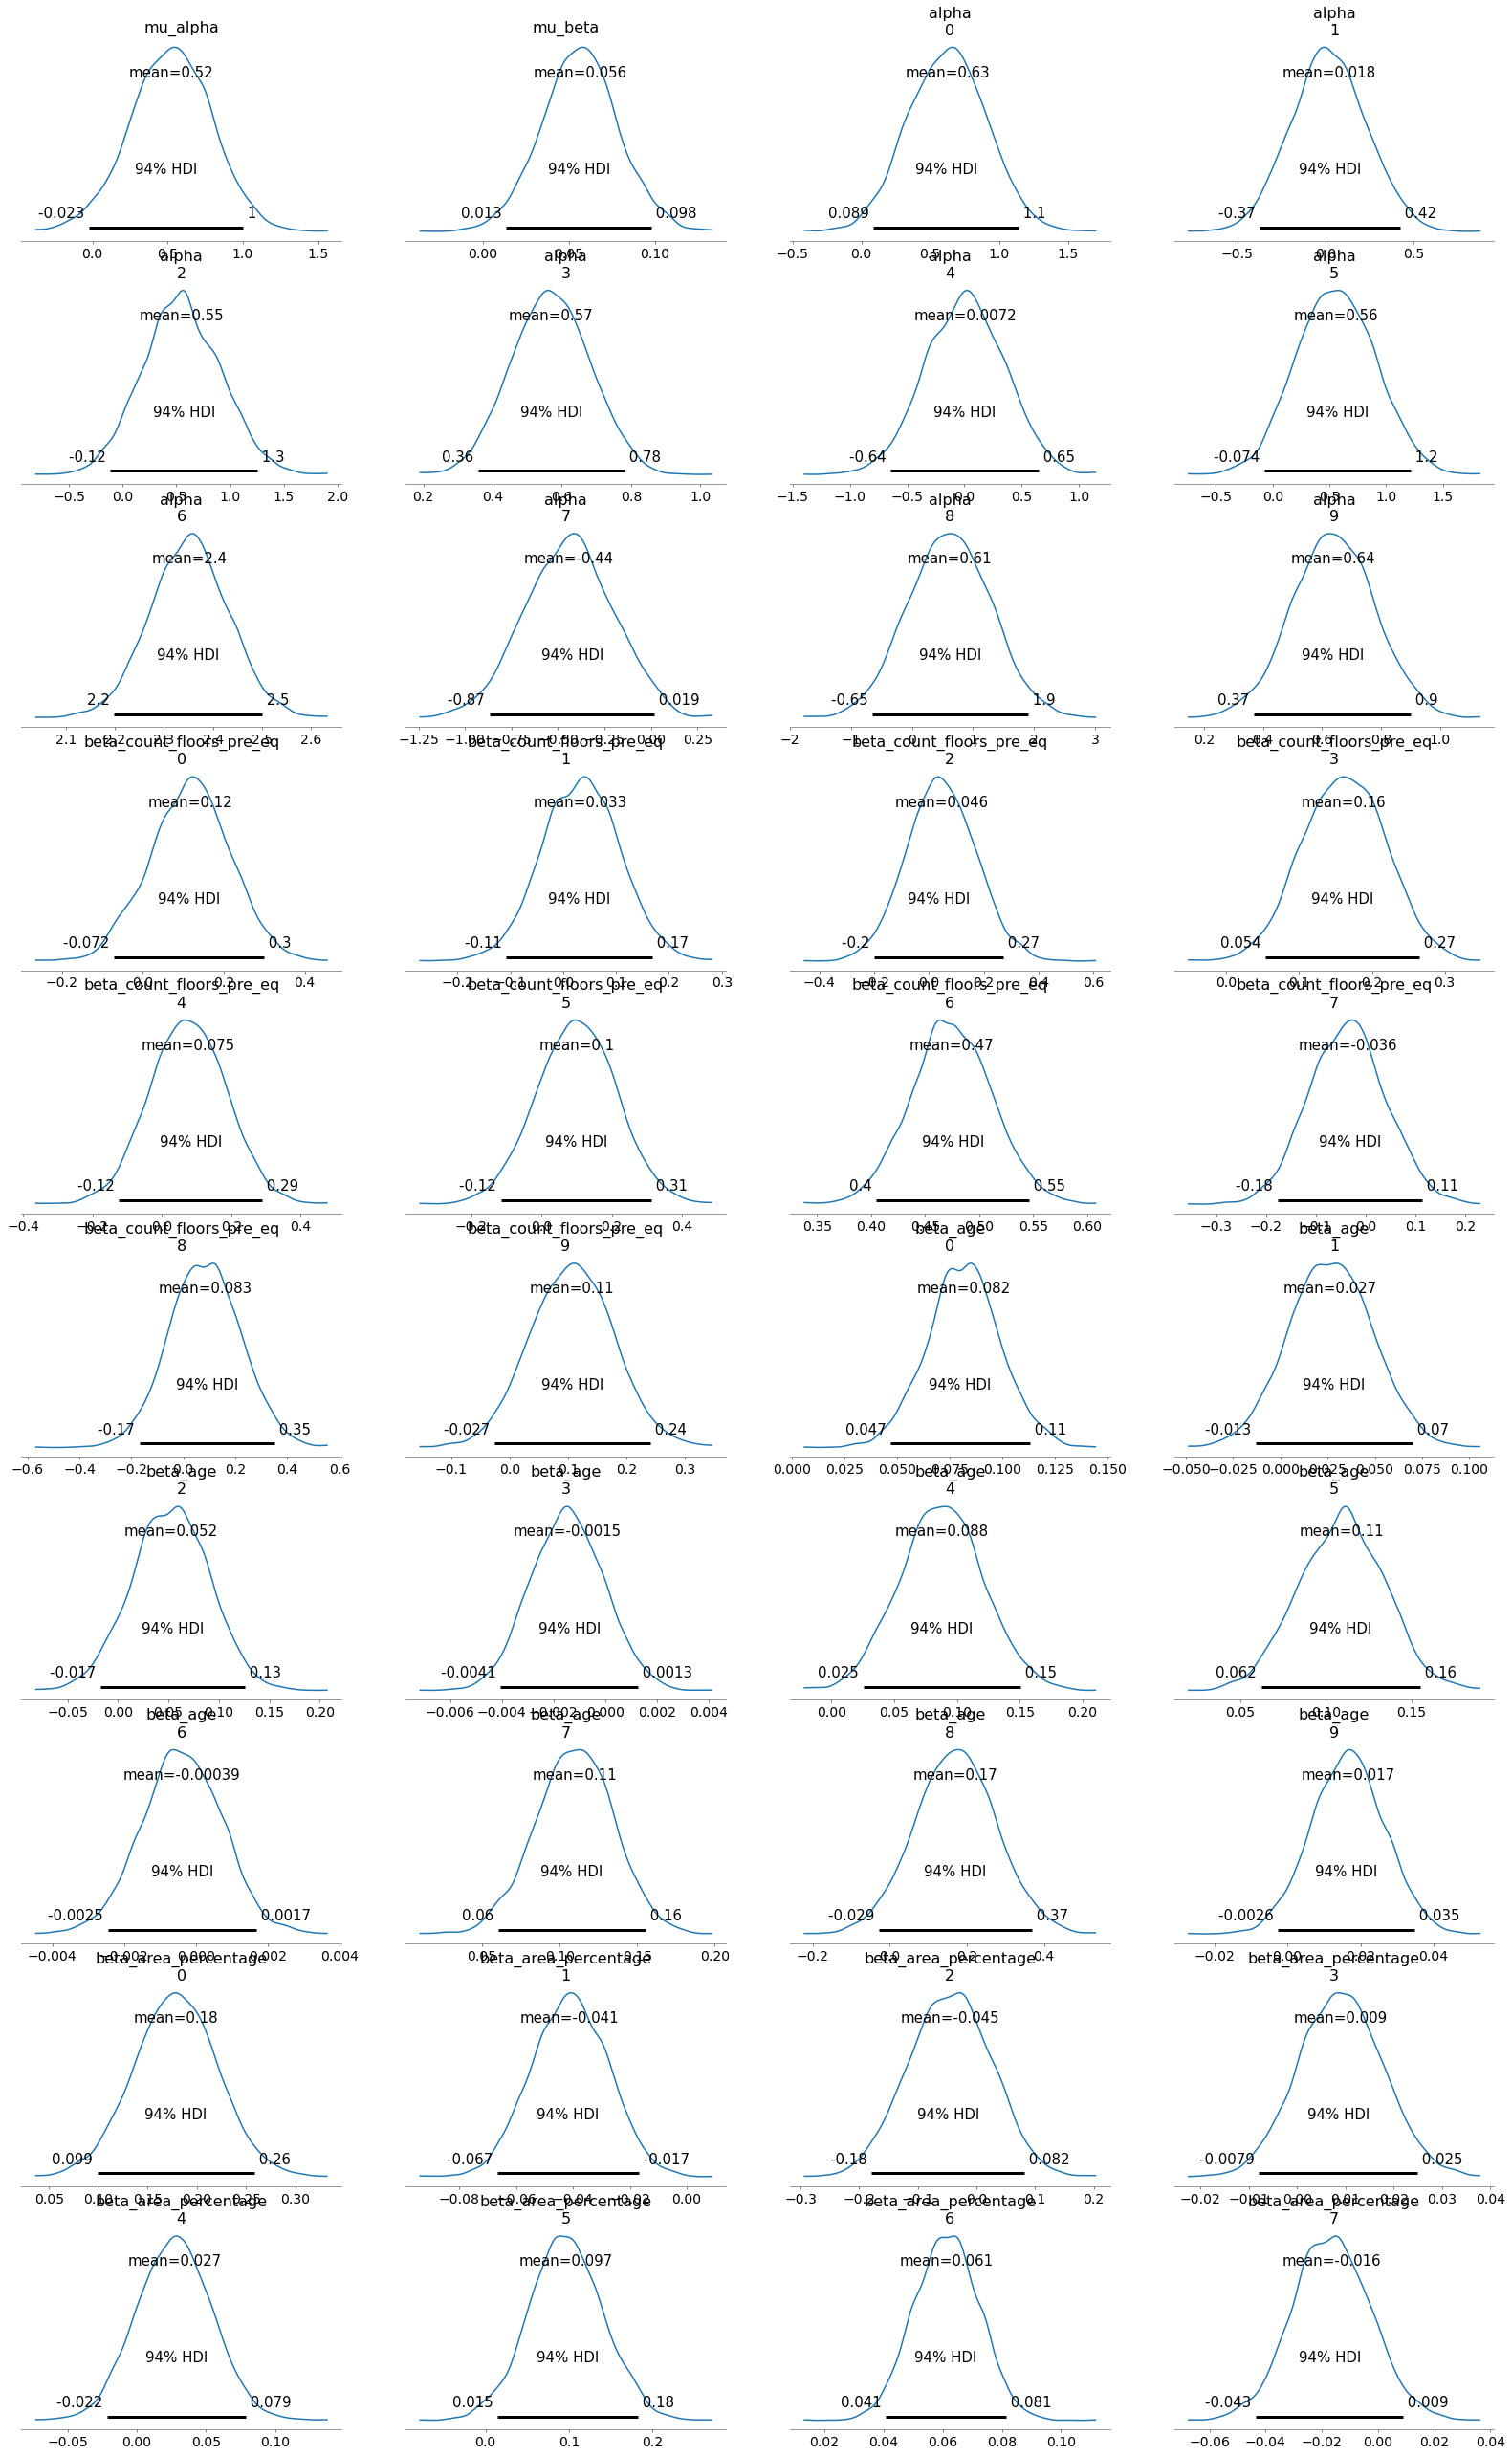

In [ ]:
az.plot_posterior(hier__trace)

# TESTING:

In [ ]:
data_test.head()
vars = ['count_floors_pre_eq', 'age', 'area_percentage', 'geo_level_1_id']
X_test = data_test[vars]
X_test

,count_floors_pre_eq,age,area_percentage,geo_level_1_id
178478,1,5,9,11
66937,1,15,4,21
81388,3,35,9,10
9221,2,50,7,3
153780,2,20,6,10
...,...,...,...,...
177877,3,0,7,8
38390,3,45,7,4
147248,2,20,4,6
13165,2,60,4,26


In [ ]:
X_test['age']

178478     5
66937     15
81388     35
9221      50
153780    20
          ..
177877     0
38390     45
147248    20
13165     60
26159      0
Name: age, Length: 2998, dtype: int64

In [ ]:
y_test = data_test['damage_combined'].values

with pooled_model:
    pooled_1_trace = pm.to_inference_data(trace=pooled__trace, log_likelihood=True)
    pm.set_data({"count_floors_pre_eq": data_test['count_floors_pre_eq'], 
                 "age": data_test['age'],
                 "area_percentage": data_test['area_percentage'],
                 "geo_level_1_id": data_test['geo_level_1_id'],
                 "y":y_test})
    #Predict outcomes & probabilities
    pooled_test_pp = pm.sample_posterior_predictive(
        pooled_1_trace,
        var_names = ["damage_combined"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed = random_seed)

Sampling: [damage_combined]


In [ ]:
pred = pooled_test_pp.predictions["damage_combined"].mean(dim =['chain','draw'])
mse = mean_squared_error(pred, y_test)
print("Pooled MSE: " + str(round(mse, 2)))

Pooled MSE: 0.08


In [ ]:
pooled_test_pp

Inference data with groups:
	> posterior
	> predictions
	> observed_data
	> constant_data
	> predictions_constant_data

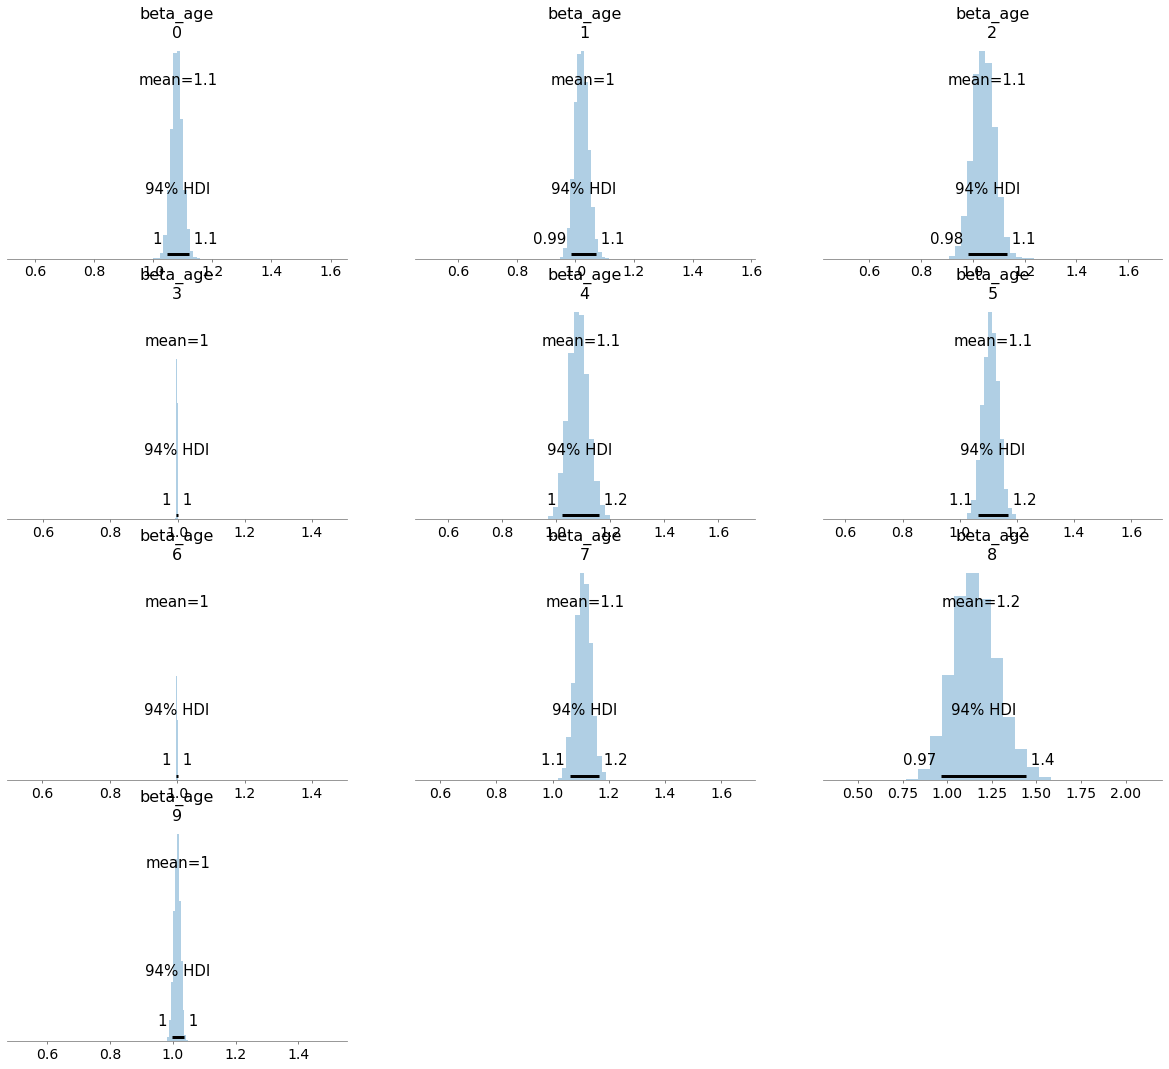

TypeError: 'NoneType' object is not callable

In [ ]:
pm.plot_posterior(hier__trace, var_names=['beta_age'], kind='hist', transform=lambda x: np.exp(x))
plt.show()(hier__trace)

In [ ]:
beta_age = hier__trace.posterior['beta_age']

array([[<Axes: title={'center': 'beta_age\n0'}>,
        <Axes: title={'center': 'beta_age\n1'}>,
        <Axes: title={'center': 'beta_age\n2'}>],
       [<Axes: title={'center': 'beta_age\n3'}>,
        <Axes: title={'center': 'beta_age\n4'}>,
        <Axes: title={'center': 'beta_age\n5'}>],
       [<Axes: title={'center': 'beta_age\n6'}>,
        <Axes: title={'center': 'beta_age\n7'}>,
        <Axes: title={'center': 'beta_age\n8'}>],
       [<Axes: title={'center': 'beta_age\n9'}>, <Axes: >, <Axes: >]],
      dtype=object)

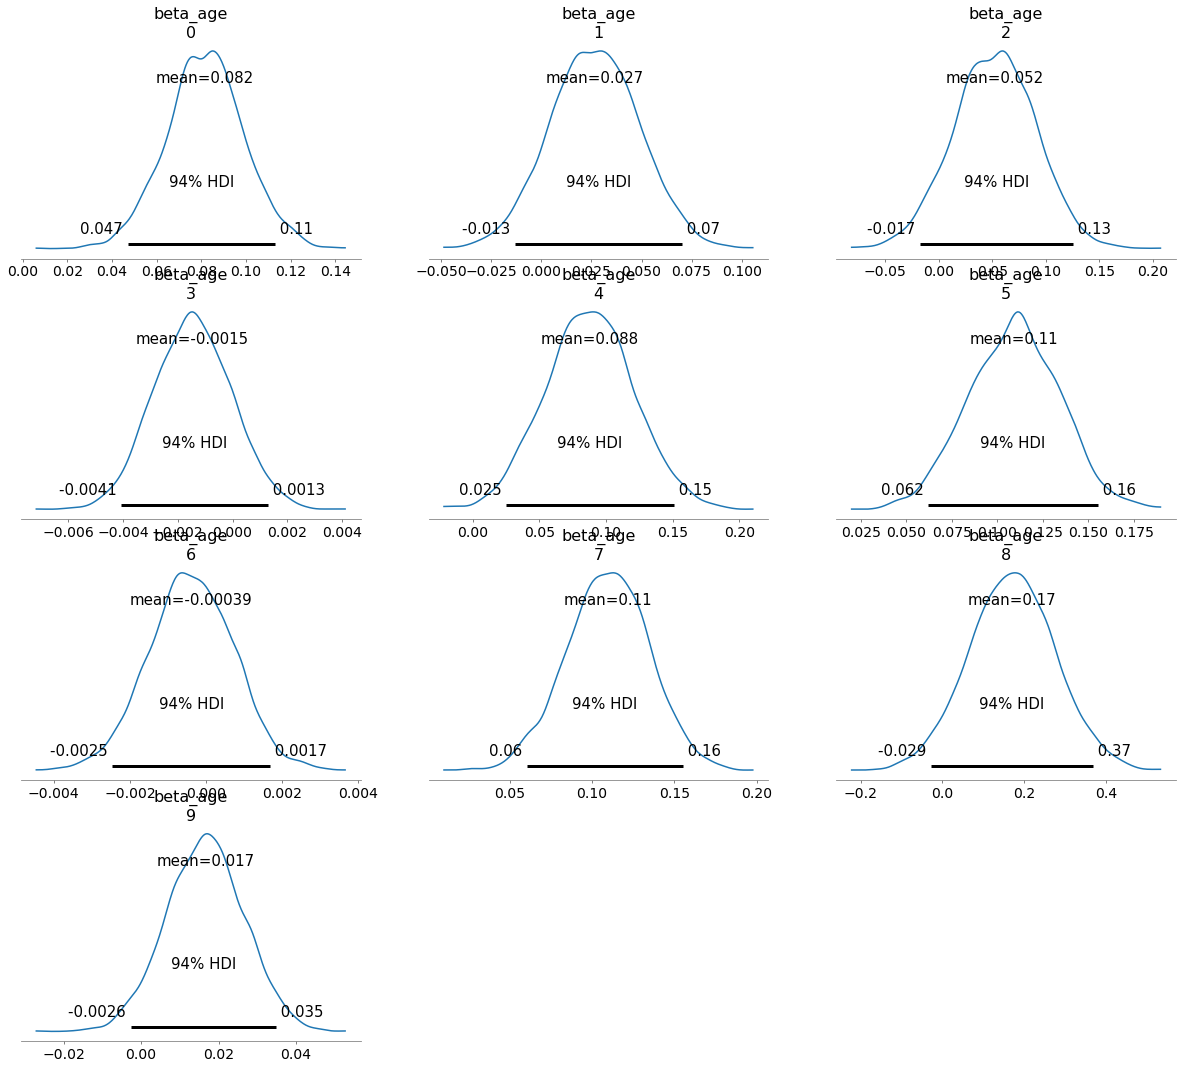

In [ ]:
az.plot_posterior(hier__trace, var_names=['beta_age'])

In [32]:
y_test = data_test['damage_combined'].values
material_idx = train_clean['primary_material'].cat.codes.values
with hier_model:
    hier_1_trace = pm.to_inference_data(trace=hier__trace, log_likelihood=True)
    pm.set_data({"count_floors_pre_eq": data_test['count_floors_pre_eq'], 
                 "age": data_test['age'],
                 "area_percentage": data_test['area_percentage'],
                 "geo_level_1_id": data_test['geo_level_1_id'],
                 "y":y_test,
                 "material_idx": data_test['primary_material'].cat.codes.values})
    #Predict outcomes & probabilities
    hier_test_pp = pm.sample_posterior_predictive(
        hier_1_trace,
        var_names = ["damage_combined"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed = random_seed)

Sampling: [damage_combined]


In [34]:
pred2 = hier_test_pp.predictions["damage_combined"].mean(dim =['chain','draw'])
mse = mean_squared_error(pred2, y_test)
print("Hierarchical MSE: " + str(round(mse, 2)))

Hierarchical MSE: 0.06


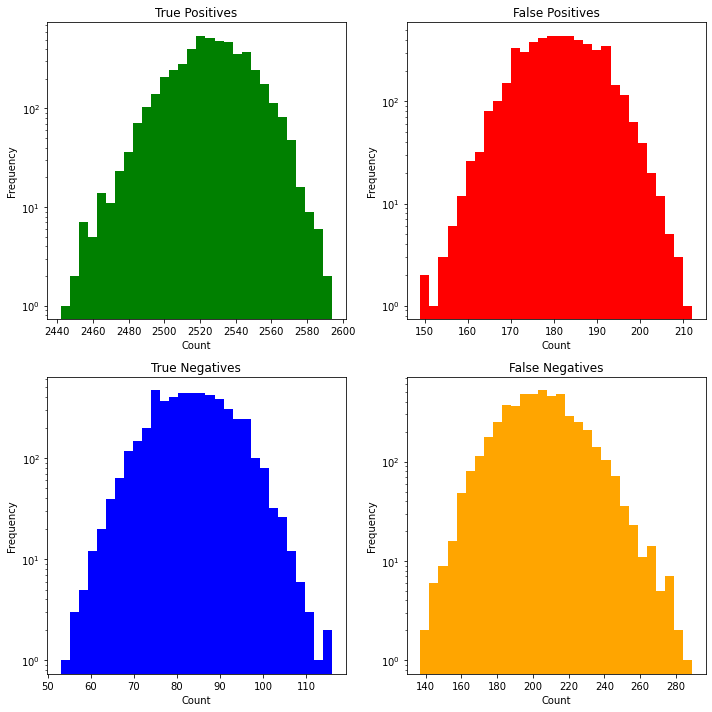

In [35]:
predictions = hier_test_pp.predictions['damage_combined'].values
num_draws = predictions.shape[1]
num_samples = predictions.shape[2]
TP = np.zeros(num_draws)
FP = np.zeros(num_draws)
TN = np.zeros(num_draws)
FN = np.zeros(num_draws)
for i in range(num_draws):
    # Average predictions over chains if needed, or thresholding if they are probabilities
    # Here it's assumed they are binary (0 or 1)
    pred_draw = predictions[0, i, :].astype(int)  # 0 index for chain

    TP[i] = np.sum((pred_draw == 1) & (y_test == 1))
    FP[i] = np.sum((pred_draw == 1) & (y_test == 0))
    TN[i] = np.sum((pred_draw == 0) & (y_test == 0))
    FN[i] = np.sum((pred_draw == 0) & (y_test == 1))


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# True Positives
axes[0, 0].hist(TP, bins=30, color='green', log=True)
axes[0, 0].set_title('True Positives')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Frequency')

# False Positives
axes[0, 1].hist(FP, bins=30, color='red', log=True)
axes[0, 1].set_title('False Positives')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Frequency')

# True Negatives
axes[1, 0].hist(TN, bins=30, color='blue', log=True)
axes[1, 0].set_title('True Negatives')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Frequency')

# False Negatives
axes[1, 1].hist(FN, bins=30, color='orange', log=True)
axes[1, 1].set_title('False Negatives')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Frequency')

fig.tight_layout()

plt.show()

In [36]:
y_test = data_test['damage_combined'].values
with pooled_model:
    pooled_1_trace = pm.to_inference_data(trace=pooled__trace, log_likelihood=True)
    pm.set_data({"count_floors_pre_eq": data_test['count_floors_pre_eq'], 
                 "age": data_test['age'],
                 "area_percentage": data_test['area_percentage'],
                 "geo_level_1_id": data_test['geo_level_1_id'],
                 "y":y_test})
    #Predict outcomes & probabilities
    pooled_test_pp = pm.sample_posterior_predictive(
        pooled_1_trace,
        var_names = ["damage_combined"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed = random_seed)

Sampling: [damage_combined]


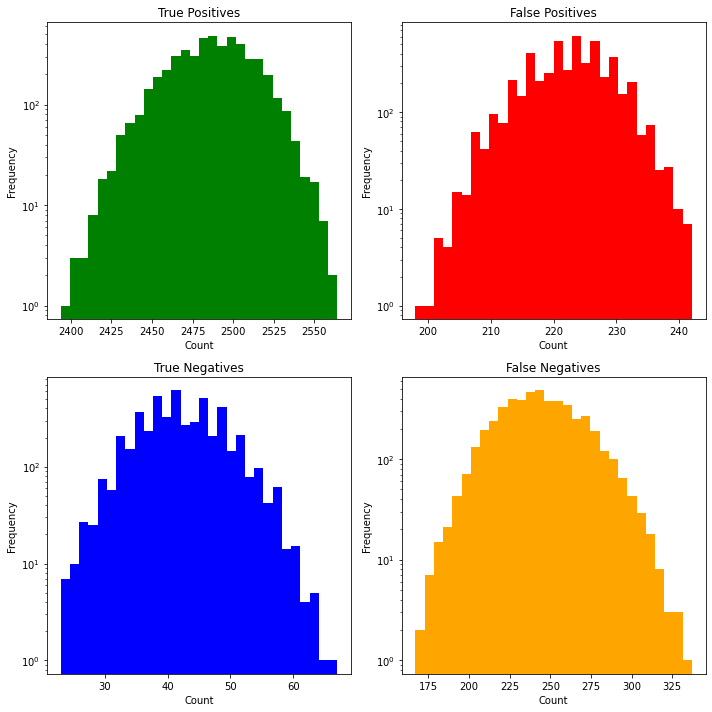

In [37]:
predictions = pooled_test_pp.predictions['damage_combined'].values
num_draws = predictions.shape[1]
num_samples = predictions.shape[2]
TP = np.zeros(num_draws)
FP = np.zeros(num_draws)
TN = np.zeros(num_draws)
FN = np.zeros(num_draws)
for i in range(num_draws):
    # Average predictions over chains if needed, or thresholding if they are probabilities
    # Here it's assumed they are binary (0 or 1)
    pred_draw = predictions[0, i, :].astype(int)  # 0 index for chain

    TP[i] = np.sum((pred_draw == 1) & (y_test == 1))
    FP[i] = np.sum((pred_draw == 1) & (y_test == 0))
    TN[i] = np.sum((pred_draw == 0) & (y_test == 0))
    FN[i] = np.sum((pred_draw == 0) & (y_test == 1))


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# True Positives
axes[0, 0].hist(TP, bins=30, color='green', log=True)
axes[0, 0].set_title('True Positives')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Frequency')

# False Positives
axes[0, 1].hist(FP, bins=30, color='red', log=True)
axes[0, 1].set_title('False Positives')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Frequency')

# True Negatives
axes[1, 0].hist(TN, bins=30, color='blue', log=True)
axes[1, 0].set_title('True Negatives')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Frequency')

# False Negatives
axes[1, 1].hist(FN, bins=30, color='orange', log=True)
axes[1, 1].set_title('False Negatives')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Frequency')

fig.tight_layout()

plt.show()